In [1]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers
import matplotlib.pyplot as plt
import time

In [2]:
class Xetle(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print(str(epoch) + ', ', end='')


        
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Ortalamanın mütləq xətası [AZN]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Məşğələ Xətası')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Dəyər Xətası')
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Otralamanın Kvadrat Xətası[AZN^2]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Məşğələ Xətası')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Dəyər Xətası')
  plt.legend()

In [3]:
# Maksimal sətirlərin sayı
pd.set_option('display.max_rows', 5000)
# Maksimal sütunların sayı
pd.set_option('display.max_columns', 5000)
# Enin uzunluğu
pd.set_option('display.width', 1000)

In [4]:
data = 'goals.csv'

In [5]:
column_names = ['ONE', 'X', 'TWO', 'OVER25']

raw_dataset = pd.read_csv(data, names=column_names, na_values = "?", comment='\t', sep=",", skipinitialspace=True,
                          encoding='ISO-8859-1')
dataset = raw_dataset.copy()

In [6]:
dataset.head()

,ONE,X,TWO,OVER25
0,8.62,4.69,1.41,1
1,1.56,4.33,5.88,1
2,2.52,3.10,3.12,0
3,2.90,3.10,2.67,0
4,1.46,4.32,7.90,0


In [7]:
dataset.isna().sum()

ONE       0
X         0
TWO       0
OVER25    0
dtype: int64

In [8]:
# Burada məşğələ üçün datasetimizi yaradırıq, bu zaman ümumi dataseti 80 faiz həcmində məlumatı məşğələ üçün ayırırıq
train_dataset = dataset.sample(frac=0.8,random_state=0)
# Burada test dataseti hazırlayırıq, bu zaman ümumi datasetdən məşğələ datasetini çıxırıq və yerdə qalanı test üçün saxlayırıq
test_dataset = dataset.drop(train_dataset.index)

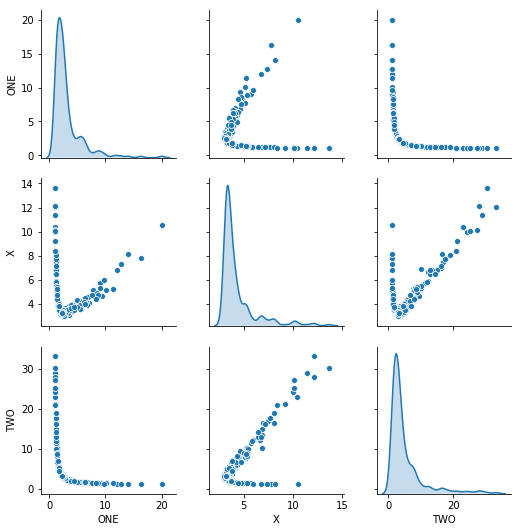

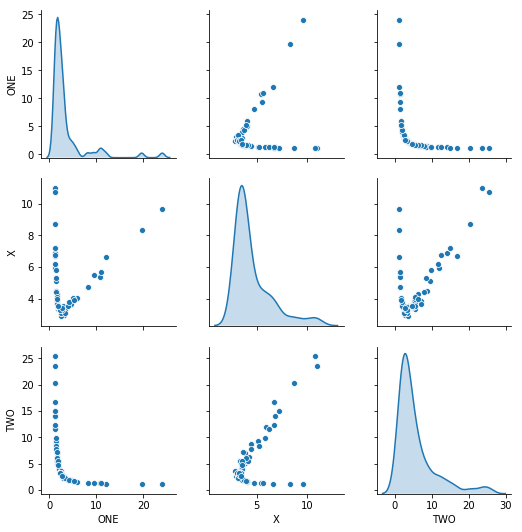

In [10]:
# Məlumatı vizualizasiya edirik
sns_plot = sns.pairplot(train_dataset[["ONE", "X", "TWO"]], diag_kind="kde")
sns.pairplot(test_dataset[["ONE", "X", "TWO"]], diag_kind="kde")
# Şəkli yaddaşa veririk.
sns_plot.savefig('Soccer.png')

In [11]:
# Məşğələ məlumatlarına baxırıq
train_dataset.describe()

,ONE,X,TWO,OVER25
count,250.000000,250.000000,250.000000,250.000000
mean,3.160640,4.338280,5.286680,0.552000
std,2.579319,1.789448,5.563185,0.498286
min,1.070000,2.970000,1.120000,0.000000
25%,1.602500,3.312500,2.225000,0.000000
50%,2.365000,3.615000,3.295000,1.000000
75%,3.417500,4.435000,5.787500,1.000000
max,19.970000,13.620000,33.170000,1.000000


In [12]:
# Test məlumatlarına baxırıq.
test_dataset.describe()

,ONE,X,TWO,OVER25
count,63.000000,63.000000,63.000000,63.000000
mean,3.540159,4.570952,5.675556,0.539683
std,4.145862,1.899698,5.344259,0.502426
min,1.100000,2.890000,1.120000,0.000000
25%,1.575000,3.350000,2.355000,0.000000
50%,2.220000,3.780000,3.580000,1.000000
75%,3.135000,5.330000,6.670000,1.000000
max,24.020000,10.980000,25.400000,1.000000


In [13]:
# qiyməti siyahıdan çıxırıq və məlumatlara baxırıq.
train_stats = train_dataset.describe()
train_stats.pop("OVER25")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
ONE,250.0,3.16064,2.579319,1.07,1.6025,2.365,3.4175,19.97
X,250.0,4.33828,1.789448,2.97,3.3125,3.615,4.4350,13.62
TWO,250.0,5.28668,5.563185,1.12,2.2250,3.295,5.7875,33.17


In [14]:
# Biz burada qiyməti tapacağımıza görə həm train, həm də test dataset-dən price sütununu silməliyik.
train_labels = train_dataset.pop('OVER25')
test_labels = test_dataset.pop('OVER25')

In [15]:
# Normallaşdırıcı funksiya
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

# məşğələ və test dataseti normallaşdırırıq
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
# Aşağıdakı ikisini comment etsəniz, bu zaman real normallaşdırılmış məlumat işə düşəcəkdir.
normed_train_data = train_dataset
normed_test_data = test_dataset

In [83]:
# Model hazırlamaq üçün funksiya. Burada əlbəttə ki, layer qatlarını parametrləşdirərək, funksiya ilə təyin edə bilərik.
# Hələlik isə belə sadə qalsın.
def build_model():
    model = keras.Sequential()
    model.add(layers.Dense(16, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]))
    model.add(layers.Dense(32, activation=tf.nn.relu))
    model.add(layers.Dense(64, activation=tf.nn.relu))
    model.add(layers.Dense(32, activation=tf.nn.relu))
    model.add(layers.Dense(16, activation=tf.nn.relu))
    model.add(layers.Dense(1)) 
    optimizer = tf.keras.optimizers.RMSprop(0.005)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
    return model

In [84]:
# Modelimizi düzəldirik
model = build_model()

In [85]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 16)                64        
_________________________________________________________________
dense_25 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_26 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_27 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_28 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 17        
Total params: 5,345
Trainable params: 5,345
Non-trainable params: 0
_________________________________________________________________


In [86]:
# normallaşdırılmış datasetdə hər hansı bir boşluq varsa, onları 0 ilə əvəzləyirik
normed_train_data.fillna(0, inplace=True)
# Məlumat belə görünür
normed_train_data[:10]

,ONE,X,TWO
65,1.25,6.90,10.13
253,1.40,5.10,7.59
208,3.38,3.31,2.25
156,6.86,4.59,1.48
108,1.99,3.52,3.93
150,1.19,7.00,16.37
134,1.21,6.83,14.86
116,12.00,6.79,1.23
74,1.24,6.63,12.15
261,1.18,7.47,16.94


In [87]:
# test datadan 10 sətir götürüb modelimizi test edirik. Nəticədə qiymətlər çıxır. Deyə bilərik ki, model funksionaldır.
example_batch = normed_test_data[:10]
example_result = model.predict(example_batch)
print(example_result)

[[ 0.0307075 ]
 [ 0.05743945]
 [-0.03523655]
 [ 0.02394405]
 [ 0.03082342]
 [ 0.23179974]
 [ 0.01406334]
 [-0.01246674]
 [ 0.03922985]
 [ 0.02848078]]


In [88]:
# epoch dataset üzərində məşğələlərin sayını bildirir. Yəni, 1 epoch modelin bütün məlumatları 1 dəfə "görməsi" deməkdir.
# Bizim modeldə 3750 daha yaxşı görünür, ona görə də bu rəqəmi qeyd etmişəm.
epoch = 1000

# Aşağıdakı qrafikə baxanda aydın olur ki, xəta payı müəyyən epoch sayından sonra x xəttinə paralel gedir. Bu o deməkdir ki,
# modelin öyrənməyində artıq heç bir inkişaf yoxdur. Yəni, xəta payı daha da aşağı enmir. (Qrafikə baxanda aydın olur ki. 
# xəta payı yuxarıdan başlayır və epoch sayı artıqca aşağı doğru hərəkət edir və bir nöqtədə aşağı hərəkətini saxlayır,
# y xəttinə paralel gedir. Bundan sonra modelin öyrənməsinə gərək qalmır. early_stop bu nöqtəni təyin edir və modelin 
# öyrənmə prosesini dayandırır.)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# modeli burada öyrədirik və bütün məlumatı history dəyişkənində saxlayırıq.
history = model.fit(
  normed_train_data, 
    train_labels,
  epochs=epoch, 
    validation_split = 0.2, 
    verbose=0, callbacks=[Xetle(), early_stop]
)

# Modeli yaddaşa vermək üçün. Sonluğu .model kimi təyin eləmişəm. Siz istədiyiniz kimi təyin edə bilərsiniz. Çox hallarda
# h5py kimi qeyd edirlər. Yaddaşa verdikdən sonra modeli daha sonra load_model() metodu ilə yükləyib istifadə edə bilərsiniz.
model.save('modelin-adi-' + str(int(time.time())) + '.model')
# early_stop modelin öyrənilməsi ərzində deqradasiya gedərsə öyrənmə prosesini avtomatik dayandırır. Bu parametri silərək modeli
# tam öyrədə bilərsiniz. Bu zaman isə overfitting əmələ gələcək. Overfitting haqqında isə daha sonra ətraflı yazacam

# Aşağıda testlər apararaq minimal uzaqlaşma xətasını tapmağa çalışmışam.
# epoch(3750) = 975.94
# epoch(4000) = 983.17
# epoch(3800) = 981.18
# epoch(3700) = 993.35
# epoch(3760) = 999.12

# Nəticədə 3750 istifadə etdim


0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 

In [89]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
22,0.223569,0.450597,0.223569,0.247012,0.486046,0.247012,22
23,0.231566,0.477360,0.231566,0.252570,0.487946,0.252570,23
24,0.232143,0.470671,0.232143,0.258373,0.498870,0.258373,24
25,0.241557,0.490175,0.241557,0.246711,0.484143,0.246711,25
26,0.221456,0.454994,0.221456,0.249735,0.492121,0.249735,26


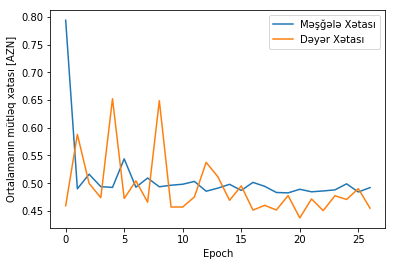

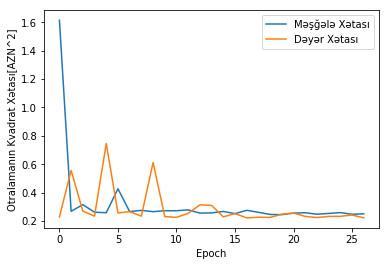

In [90]:
plot_history(history)

Mütləq xəta ortalaması:  0.52


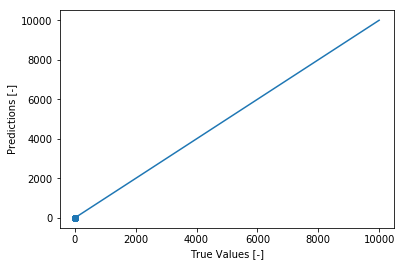

In [91]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

# Yəni, əldə etdiyimiz nəticə bu rəqəm qədər artıq və ya az ola bilər :) 
# Nə qədər aşağı olsa deməli model o qədər də yaxşı işləyir
print("Mütləq xəta ortalaması: {:5.2f}".format(mae))

test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [-]')
plt.ylabel('Predictions [-]')
# plt.axis('equal')
# plt.axis('square')
# plt.xlim([0,plt.xlim()[1]])
# plt.ylim([0,plt.ylim()[1]])
# _ = plt.plot([-100, 100], [-100, 100])
plt.plot([0, 10000], [0, 10000])


# Yenə də qrafikə baxanda aydın olur ki, hələ görüləcək işlərimiz çoxdur. Yəni modeli çox optimallaşdırmalıyıq.
# Xəttimiz tam olaraq da paylanmanı təmsil etmir. Bir az daha əyri xətt daha yaxşı olardı.

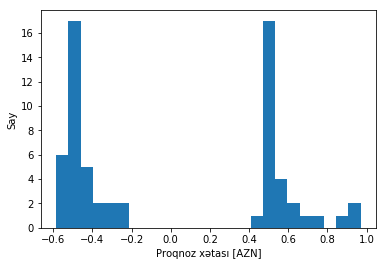

In [92]:
# Xəta/say histoqramı
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Proqnoz xətası [-]")
_ = plt.ylabel("Say")

In [93]:
# Burada real məlumatlardan düzəltdiyimi test məlumatlar haqqında proqnoz veririk
test_predictions = model.predict(normed_test_data[:10]).flatten()
# Proqnozu çap edirik
test_predictions

array([0.51407164, 0.47718507, 0.5248705 , 0.5057688 , 0.49274656,
       0.95994014, 0.5041758 , 0.51906294, 0.54195523, 0.5627557 ],
      dtype=float32)

In [104]:
# Burada isə özümüz panda dataframe düzəldirik
new_data = pd.DataFrame({ 'ONE': [2.07], 'X': [3.20], 'TWO': [3.15] })
# norm funksiyası ilə məlumatı normallaşdıra bilərik
normalized_new_data = new_data

In [105]:
# Məlumatı modelə ötürürük və nəticə əldə edirik
model.predict(new_data).flatten()

array([0.48519176], dtype=float32)